# **DEMO PRÁCTICA: Fine-Tuning de RT-DETR para Detección de EPP (Cascos)**
Por: Bryan Daniel Martínez Cabezas

Objetivo: Esta demo demostrará el proceso de fine-tuning (re-entrenamiento) de un modelo RT-DETR de última generación. Tomaremos el modelo pre-entrenado y lo especializaremos en una tarea de seguridad industrial: detectar si los trabajadores en una obra llevan puesto su casco.

In [ ]:
# Instalar las librerías necesarias
!pip install -q transformers roboflow supervision

In [ ]:


from google.colab import drive
drive.mount('/content/drive')

print("¡Google Drive conectado!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
¡Google Drive conectado!


In [ ]:
# Importar las librerías que acabamos de instalar
import roboflow
import supervision as sv
import torch
import os
from huggingface_hub import hf_hub_download # Para descargar el modelo
from transformers import AutoImageProcessor, AutoModelForObjectDetection

# Para manejar imágenes y videos
import cv2
import numpy as np
from PIL import Image
import requests

# Para dibujar en las imágenes
import supervision.draw.utils as sv_utils

Ahora usamos un Dataset ya existente de ROBOFLOW en este caso "hard hat Computer Vision Dataset" para la clasificacion de obreros con casco si se desea replicar esto es necesario hacer fork a tu espacio de trabajo en ROBOFLOW dicho dataset o descargarlo en zip y subirlo a drive ambas maneras son correctas
Aclarando que tiene que ser en formato COCO


In [ ]:

from roboflow import Roboflow
rf = Roboflow(api_key="OM4F0VZn2AsMfFvICgeE")
project = rf.workspace("super-rze6a").project("hard-hat-sfsaw-tui5k")
version = project.version(1)
dataset = version.download("coco")

# --- Guardar las rutas
import os
DATA_ROOT = os.path.join(dataset.location)
TRAIN_IMG_DIR = os.path.join(DATA_ROOT, "train")
TRAIN_ANN_FILE = os.path.join(DATA_ROOT, "train", "_annotations.coco.json")
VAL_IMG_DIR = os.path.join(DATA_ROOT, "valid")
VAL_ANN_FILE = os.path.join(DATA_ROOT, "valid", "_annotations.coco.json")

print(f"Dataset descargado en: {DATA_ROOT}")
print(f"Anotaciones de entrenamiento: {TRAIN_ANN_FILE}")

loading Roboflow workspace...
loading Roboflow project...
Dataset descargado en: /content/hard-hat-1
Anotaciones de entrenamiento: /content/hard-hat-1/train/_annotations.coco.json


In [ ]:
import json
import torch
from transformers import AutoConfig, AutoImageProcessor, AutoModelForObjectDetection

# 1. Definimos el checkpoint
checkpoint = "PekingU/rtdetr_r50vd_coco_o365"

# 2. ¡PRIMERO! Leemos las clases de nuestro dataset
with open(TRAIN_ANN_FILE, 'r') as f:
    coco_data = json.load(f)

categories = coco_data['categories']
id2label = {cat['id']: cat['name'] for cat in categories}
label2id = {cat['name']: cat['id'] for cat in categories}

print(f"Nuestras clases (leídas primero): {list(label2id.keys())}")

# 3. Cargamos la CONFIGURACIÓN (el "plano") del modelo
config = AutoConfig.from_pretrained(checkpoint)

# 4. MODIFICAMOS EL PLANO en memoria
config.id2label = id2label
config.label2id = label2id
config.num_labels = len(categories)

# 5. Cargamos el procesador de imágenes (esto no cambia)
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

# 6. ¡EL PASO CLAVE! Cargamos el modelo USANDO nuestro plano modificado
# Esto SÍ fuerza la demolición de la cabeza
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    config=config,  # <--- Le pasamos nuestro plano de 4 clases
    ignore_mismatched_sizes=True, # <--- Le decimos: "Ignora el error de que las cabezas no coinciden y reemplázala"
)

# 7. Movemos el modelo a la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("\n¡Modelo cargado, re-configurado (correctamente) y movido a la GPU!")

Nuestras clases (leídas primero): ['hat', 'head', 'helmet', 'person']



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd_coco_o365 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoin


¡Modelo cargado, re-configurado (correctamente) y movido a la GPU!


In [ ]:
import torchvision
from torchvision.datasets import CocoDetection
from PIL import Image
import os

# 1. Definimos una clase "Dataset" personalizada
class CocoDetectionDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, image_processor):
        # Llama al constructor de la clase base (CocoDetection)
        super(CocoDetectionDataset, self).__init__(img_folder, ann_file)
        # Guardamos nuestro procesador de imágenes
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # Obtenemos la imagen y sus anotaciones usando la clase base
        img, target = super(CocoDetectionDataset, self).__getitem__(idx)

        # Convertimos la imagen a formato RGB (por si acaso alguna es blanco y negro)
        image = img.convert('RGB')

        # Preparamos las anotaciones en el formato que el procesador espera
        # (un diccionario de "image_id", "annotations")
        annotations = [{'image_id': idx, 'annotations': target}]

        # AQUÍ OCURRE LA MAGIA:
        # Usamos el procesador para transformar la imagen Y las anotaciones
        # Esto cambia el tamaño de la imagen, la normaliza Y ajusta las cajas (bboxes)
        encoding = self.image_processor(images=image, annotations=annotations, return_tensors="pt")

        # El procesador devuelve los tensores en un "batch" (lote),
        # pero el dataset necesita devolver un solo elemento.
        # Por eso usamos squeeze() para quitar la dimensión extra.
        pixel_values = encoding["pixel_values"].squeeze()
        labels = encoding["labels"][0] # Obtenemos las etiquetas del primer (y único) elemento

        return {"pixel_values": pixel_values, "labels": labels}

# 2. Creamos nuestro dataset de entrenamiento
train_dataset = CocoDetectionDataset(
    img_folder=TRAIN_IMG_DIR,
    ann_file=TRAIN_ANN_FILE,
    image_processor=image_processor
)

# 3. Creamos nuestro dataset de validación
val_dataset = CocoDetectionDataset(
    img_folder=VAL_IMG_DIR,
    ann_file=VAL_ANN_FILE,
    image_processor=image_processor
)

print(f"¡Datasets listos!")
print(f"Imágenes de entrenamiento: {len(train_dataset)}")
print(f"Imágenes de validación: {len(val_dataset)}")

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
¡Datasets listos!
Imágenes de entrenamiento: 3500
Imágenes de validación: 1000


In [ ]:


from transformers import TrainingArguments, Trainer
import torch

# 1. Definimos una función para "agrupar" los datos (collate_fn)
# Esto es necesario porque las imágenes pueden tener diferentes números de objetos
def collate_fn(batch):
    # Tomamos los valores de píxeles y los apilamos
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    # Las etiquetas son una lista, no las apilamos
    labels = [item["labels"] for item in batch]
    # Devolvemos un diccionario
    return {"pixel_values": pixel_values, "labels": labels}

# 2. Definimos los Argumentos de Entrenamiento
training_args = TrainingArguments(
    output_dir="rtdetr-finetuned-cascos-30-epoch",     # Directorio donde se guardará el modelo
    per_device_train_batch_size=4,           # Cuántas imágenes entrenar a la vez (lotes de 4)
    num_train_epochs=40,                     # Cuántas "pasadas" completas hacer por el dataset (20 epochs)
    fp16=True,                               # Usar "precisión mixta" (fp16) para acelerar el entrenamiento en la T4
    save_strategy="epoch",                   # Guardar un checkpoint al final de cada epoch
    logging_strategy="epoch",                # Reportar las métricas de pérdida (loss) al final de cada epoch
    do_eval=True,
    learning_rate=1e-5,                      # Tasa de aprendizaje (un valor estándar para fine-tuning)
    weight_decay=1e-4,                       # Regularización para evitar sobreajuste
    remove_unused_columns=False,             # No borrar columnas (importante)
    push_to_hub=False,                       # No subir el modelo a Hugging Face (a menos que quieras)
    report_to="none",
)

# 3. Inicializamos el Entrenador (el "Trainer")
trainer = Trainer(
    model=model,                             # Nuestro modelo RT-DETR ya re-configurado
    args=training_args,                      # Nuestros argumentos de entrenamiento
    train_dataset=train_dataset,             # Nuestro dataset de entrenamiento
    eval_dataset=val_dataset,                # Nuestro dataset de validación
    data_collator=collate_fn,                # Nuestra función para agrupar los lotes
)

print("¡Entrenador listo!")
print(f"Vamos a entrenar durante {training_args.num_train_epochs} epochs.")
print(f"Los checkpoints se guardarán en: {training_args.output_dir}")

¡Entrenador listo!
Vamos a entrenar durante 40 epochs.
Los checkpoints se guardarán en: rtdetr-finetuned-cascos-30-epoch


In [ ]:
print("¡Comenzando el fine-tuning de RT-DETR!")
print("Esto puede tardar varias horas.")

# ¡A entrenar!
trainer.train()

print("¡ENTRENAMIENTO COMPLETADO!")
print(f"El modelo final está guardado en la carpeta: {training_args.output_dir}")

¡Comenzando el fine-tuning de RT-DETR!
Esto puede tardar varias horas.


Step,Training Loss
875,25.850700
1750,13.621200
2625,12.745500
3500,12.282900
4375,11.952300
5250,11.635900
6125,11.375800
7000,11.057400
7875,10.856400
8750,10.568700


¡ENTRENAMIENTO COMPLETADO!
El modelo final está guardado en la carpeta: rtdetr-finetuned-cascos-30-epoch


In [ ]:
from google.colab import drive
import os

print("Conectando Google Drive...")
drive.mount('/content/drive')
print("¡Google Drive conectado!")

# 1. Definimos una carpeta de guardado "limpia"
MODELO_FINAL_DIR = "modelo-final-rtdetr-cascos"

# 2. Guardamos el modelo (¡esto SÍ guarda la config!)
print(f"Guardando el modelo final en {MODELO_FINAL_DIR}...")
trainer.save_model(MODELO_FINAL_DIR)

# 3. Guardamos también el procesador de imágenes
image_processor.save_pretrained(MODELO_FINAL_DIR)

# 4. Definimos la ruta en tu Google Drive
DRIVE_PATH = "/content/drive/MyDrive/rt-detr cascos"

# 5. Creamos la carpeta en Drive (si no existe)
!mkdir -p "{DRIVE_PATH}"

# 6. Copiamos la carpeta del modelo a Drive
print(f"Copiando el modelo a {DRIVE_PATH}...")
!cp -r {MODELO_FINAL_DIR} "{DRIVE_PATH}"

print(f"¡ÉXITO! Tu modelo está a salvo en Google Drive en la carpeta: {DRIVE_PATH}")

Conectando Google Drive...


Cargando nuestro modelo fine-tuned desde: modelo-final-rtdetr-cascos
Probando con la imagen: /content/hard-hat-1/valid/hard_hat_workers4519_png.rf.11cb1f48622e87c88963d9c7b536c4b0.jpg
¡Mostrando resultados (Original vs. Inferido con umbral 0.5)!


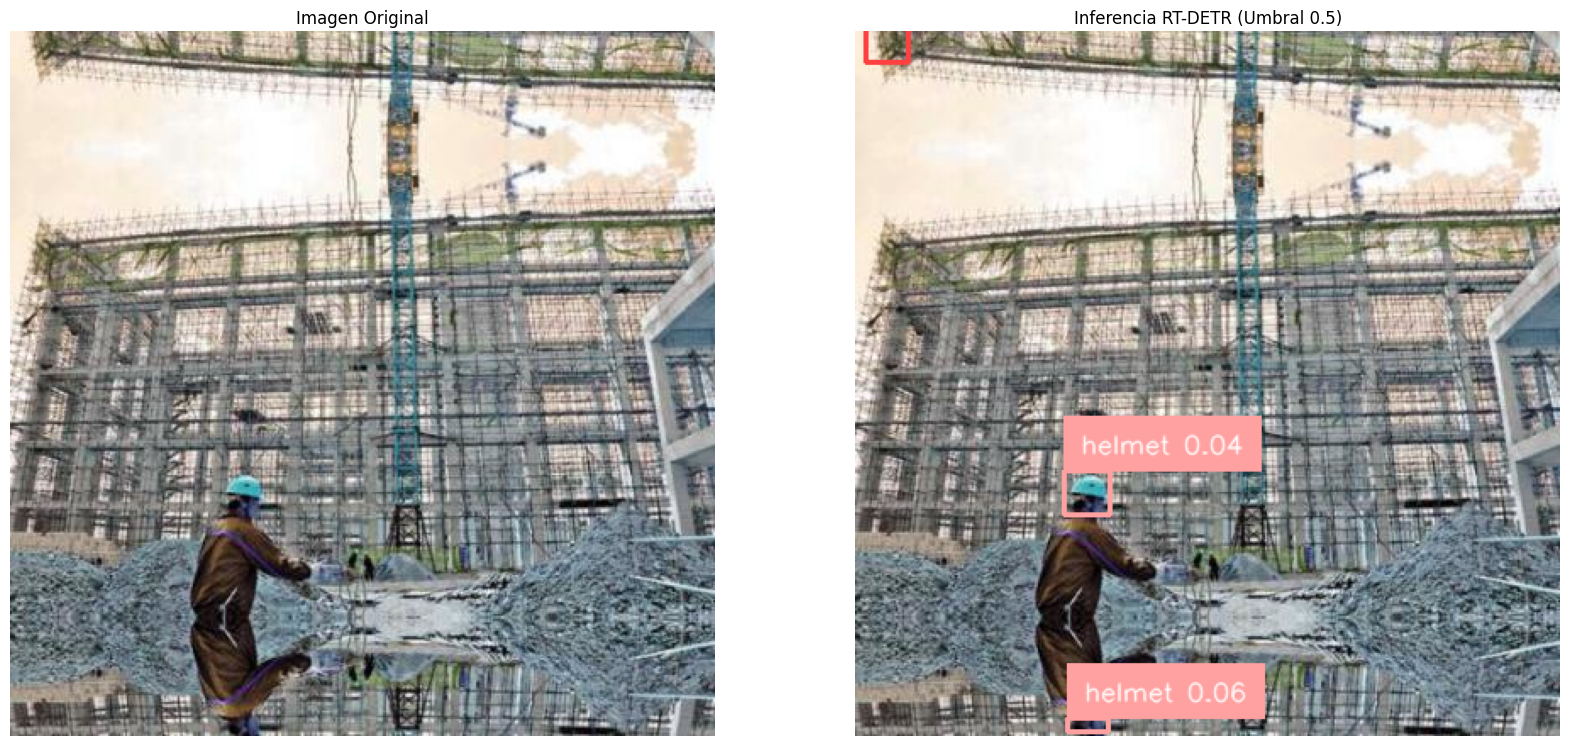

In [ ]:
from PIL import Image
import torch
import supervision as sv
import os
import numpy as np

# 1. Cargamos nuestro modelo guardado
# (Este es el nombre de la carpeta que acabas de guardar en la Celda 19)
MODEL_PATH = "modelo-final-rtdetr-cascos"

print(f"Cargando nuestro modelo fine-tuned desde: {MODEL_PATH}")

image_processor = AutoImageProcessor.from_pretrained(MODEL_PATH)
model = AutoModelForObjectDetection.from_pretrained(MODEL_PATH)
model.to(device) # Mover a la GPU

# 2. Preparamos la imagen de prueba (tomamos una de validación)
# (VAL_IMG_DIR fue definido en la Celda 3)
image_path = os.path.join(VAL_IMG_DIR, os.listdir(VAL_IMG_DIR)[2])
image = Image.open(image_path).convert('RGB')
print(f"Probando con la imagen: {image_path}")

# 3. Procesamos la imagen y hacemos la predicción
with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt").to(device)
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]]).to(device)

    # --- AQUÍ ESTABA EL ERROR (se borró la línea '--') ---
    results = image_processor.post_process_object_detection(
        outputs,
        target_sizes=target_sizes,
        threshold=0.01 #
    )[0]

# 4. ¡DIBUJAMOS LOS RESULTADOS!
detections = sv.Detections.from_transformers(transformers_results=results)
labels = [f"{model.config.id2label[class_id]} {confidence:.2f}"
          for class_id, confidence
          in zip(detections.class_id, detections.confidence)]

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
annotated_image = np.array(image)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

# --- COMPARACIÓN LADO A LADO ---
# 5. Mostramos la imagen final
print("¡Mostrando resultados (Original vs. Inferido con umbral 0.5)!")
original_image_np = np.array(image)
sv.plot_images_grid(
    images=[original_image_np, annotated_image],
    grid_size=(1, 2),
    titles=["Imagen Original", f"Inferencia RT-DETR (Umbral {0.5})"],
    size=(20, 10)
)

In [ ]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection
from google.colab import drive
import os

# 1. Montamos Google Drive
print("Conectando Google Drive...")
drive.mount('/content/drive', force_remount=True)

# 2. Definimos las rutas (¡CORREGIDAS!)
DRIVE_PATH = "/content/drive/MyDrive/rt-detr cascos"

# --- ESTA ES LA CORRECCIÓN ---
# Este es el nombre que usaste en tu Celda 19 para guardar (visto en la imagen e41b82.png)
MODELO_FINAL_DIR = "modelo-final-rtdetr-cascos"

# La ruta completa a la carpeta que SÍ tiene los archivos config.json
DRIVE_CHECKPOINT_PATH = os.path.join(DRIVE_PATH, MODELO_FINAL_DIR)

print(f"Ruta del checkpoint corregida a: {DRIVE_CHECKPOINT_PATH}")

# 3. Cargamos el modelo y el procesador desde la carpeta de Drive
print(f"Cargando modelo y procesador...")
image_processor = AutoImageProcessor.from_pretrained(DRIVE_CHECKPOINT_PATH)
model = AutoModelForObjectDetection.from_pretrained(DRIVE_CHECKPOINT_PATH)
model.to(device) # 'device' fue definido en la Celda 2

print("¡Modelo cargado en la GPU!")

Conectando Google Drive...
Mounted at /content/drive
Ruta del checkpoint corregida a: /content/drive/MyDrive/rt-detr cascos/modelo-final-rtdetr-cascos
Cargando modelo y procesador...
¡Modelo cargado en la GPU!


In [ ]:
import json
import matplotlib.pyplot as plt
import os

# --- Definimos las rutas (asegúrate que coincidan) ---
# (Estas variables las creaste en la celda de "Cargar Modelo")
# DRIVE_CHECKPOINT_PATH = "/content/drive/MyDrive/rt-detr cascos/rtdetr-finetuned-cascos-30-epoch"
STATE_FILE = os.path.join(DRIVE_CHECKPOINT_PATH, "trainer_state.json")
# ----------------------------------------------------

print(f"Cargando historial de entrenamiento desde: {STATE_FILE}")

try:
    with open(STATE_FILE, 'r') as f:
        data = json.load(f)

    log_history = data["log_history"]

    # --- Código para graficar ---
    epochs_train = []
    losses_train = []
    epochs_eval = []
    losses_eval = []

    for entry in log_history:
        if "loss" in entry:
            epochs_train.append(entry["epoch"])
            losses_train.append(entry["loss"])
        if "eval_loss" in entry:
            epochs_eval.append(entry["epoch"])
            losses_eval.append(entry["eval_loss"])

    plt.figure(figsize=(12, 7))
    plt.plot(epochs_train, losses_train, marker='o', linestyle='-', label='Training Loss')
    plt.plot(epochs_eval, losses_eval, marker='o', linestyle='-', label='Validation Loss')
    plt.title(f'Curva de Pérdida (Loss) - {len(epochs_eval)} Epochs')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

except FileNotFoundError:
    print(f"\n¡ERROR! No se encontró el archivo: {STATE_FILE}")
    print("Asegúrate que la ruta es correcta.")
except Exception as e:
    print(f"Ocurrió un error: {e}")

Cargando historial de entrenamiento desde: /content/drive/MyDrive/rt-detr cascos/modelo-final-rtdetr-cascos/trainer_state.json

¡ERROR! No se encontró el archivo: /content/drive/MyDrive/rt-detr cascos/modelo-final-rtdetr-cascos/trainer_state.json
Asegúrate que la ruta es correcta.


In [ ]:
import supervision as sv
from tqdm import tqdm
import torch
import json
import numpy as np

# Importamos la clase correcta (esto ya estaba bien)
from supervision.metrics.mean_average_precision import MeanAveragePrecision as SupervisionMeanAveragePrecision

# 1. Preparamos la calculadora de mAP (esto ya estaba bien)
metrics = SupervisionMeanAveragePrecision()

print("Calculando mAP@50:95 sobre el set de validación...")
print("(Usando un umbral súper bajo de 0.01)")

# 2. Iteramos sobre el dataset de validación
for i in tqdm(range(len(val_dataset))):

    item = val_dataset[i]
    pixel_values = item["pixel_values"].to(device).unsqueeze(0)

    # --- Ground Truth (Verdad Absoluta) (Corregido) ---
    gt_labels = item["labels"]
    gt_xyxy = gt_labels["boxes"].cpu().numpy()
    gt_class_id = gt_labels["class_labels"].cpu().numpy()
    gt_confidences = np.ones(len(gt_xyxy), dtype=float)
    gt_detections = sv.Detections(
        xyxy=gt_xyxy,
        class_id=gt_class_id,
        confidence=gt_confidences
    )

    # --- Predicciones del Modelo ---
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        target_sizes = gt_labels["size"].unsqueeze(0).to(device)

        # --- ¡AQUÍ ESTÁ LA CORRECCIÓN! ---
        # Bajamos el umbral para capturar las predicciones de 0.04 y 0.06
        results = image_processor.post_process_object_detection(
            outputs,
            target_sizes=target_sizes,
            threshold=0.01 # <--- Umbral súper bajo
        )[0]
        # --- FIN DE LA CORRECCIÓN ---

    pred_detections = sv.Detections.from_transformers(transformers_results=results)

    # --- Actualizamos la métrica (Corregido) ---
    metrics.update(gt_detections, pred_detections)

# 3. ¡Calculamos y mostramos el resultado!
final_map_metrics = metrics.compute()

print("\n\n--- ¡MÉTRICAS mAP FINALES (con umbral 0.01)! ---")
print(final_map_metrics)

Calculando mAP@50:95 sobre el set de validación...
(Usando un umbral súper bajo de 0.01)


100%|██████████| 1000/1000 [01:02<00:00, 16.04it/s]




--- ¡MÉTRICAS mAP FINALES (con umbral 0.01)! ---
Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]                 = 0.000
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]                 = 0.000


In [ ]:
!pip install -q scikit-learn seaborn
print("¡Scikit-learn y Seaborn listos!")

¡Scikit-learn y Seaborn listos!


In [ ]:
!pip install -q --upgrade supervision
print("¡Librería 'supervision' actualizada a la última versión!")

¡Librería 'supervision' actualizada a la última versión!
